<a href="https://colab.research.google.com/github/nyihanzamaso/waste_classiffication_project/blob/main/waste_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras.layers as tkl
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import matplotlib.pyplot as plt
import os

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('archive (6).zip','r')
zip_ref.extractall()
zip_ref.close()
data_dir='archive (6)/dataset-resized'
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
validation_split=0.2,
                                                     label_mode='int',
                                                     subset='training',
                                                     seed=1227,
                                                     image_size=(224,224),
                                                     batch_size=32
                                                     )

Found 1987 files belonging to 4 classes.
Using 1590 files for training.


In [ ]:
valid_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     label_mode='int',
                                                     subset='validation',
                                                     seed=1227,
                                                     image_size=(224,224),
                                                     batch_size=32)

Found 1987 files belonging to 4 classes.
Using 397 files for validation.


In [ ]:
class_names=train_ds.class_names
print(class_names)
num_classes=len(class_names)
print(num_classes)

['glass', 'metal', 'paper', 'plastic']
4


In [ ]:
val_batches=tf.data.experimental.cardinality(valid_ds)
test_ds=valid_ds.take(val_batches // 5)
valid_ds=valid_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation bathces: %d' % tf.data.experimental.cardinality(valid_ds))
print('NUmber of test batches: %d' % tf.data.experimental.cardinality(test_ds))

AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds=valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.prefetch(buffer_size=AUTOTUNE)

Number of validation bathces: 11
NUmber of test batches: 2


In [ ]:
# use data augmentation
data_augmentation= tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)

])

In [ ]:
inputs=tf.keras.Input(shape=(224,224,3))

# choose a pre_trained model to use as basis for transfer learning
base_model=tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x=data_augmentation(inputs)
x= base_model(x, training=False)
x=tkl.GlobalAveragePooling2D()(x)
x=tkl.BatchNormalization()(x)
x=tkl.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x=tkl.Dropout(0.5)(x)
x=tkl.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x=tkl.Dropout(0.5)(x)
outputs=tkl.Dense(num_classes,activation='softmax')(x)

In [ ]:
model=tf.keras.Model(inputs,outputs)
base_learning_rate=0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
initial_epochs=80

In [ ]:
callbacks_list=[ModelCheckpoint(filepath='model.keras',
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=False,
                               mode='max')]
csv_logger=CSVLogger('modeltrainig.log',separator=',', append=False)

# train the model on the training set
history=model.fit(train_ds,
                  epochs=initial_epochs,
                  validation_data=valid_ds,
                  callbacks=(callbacks_list+[csv_logger]))

Epoch 1/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.5416 - loss: 13.7864
Epoch 1: val_accuracy improved from -inf to 0.79580, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step - accuracy: 0.5434 - loss: 13.7631 - val_accuracy: 0.7958 - val_loss: 10.1987
Epoch 2/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7748 - loss: 9.3744
Epoch 2: val_accuracy improved from 0.79580 to 0.84084, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 0.7751 - loss: 9.3588 - val_accuracy: 0.8408 - val_loss: 6.9528
Epoch 3/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8189 - loss: 6.3783
Epoch 3: val_accuracy improved from 0.84084 to 0.86787, saving model to model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 237ms/step - accuracy: 0.8191 - loss: 6.3674 - val_accuracy: 0.8679 - val_loss: 4.6782
Epoch 4/80
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8257 - loss: 4.3237
Epoch 4: val_accuracy did not improve from 0.86787

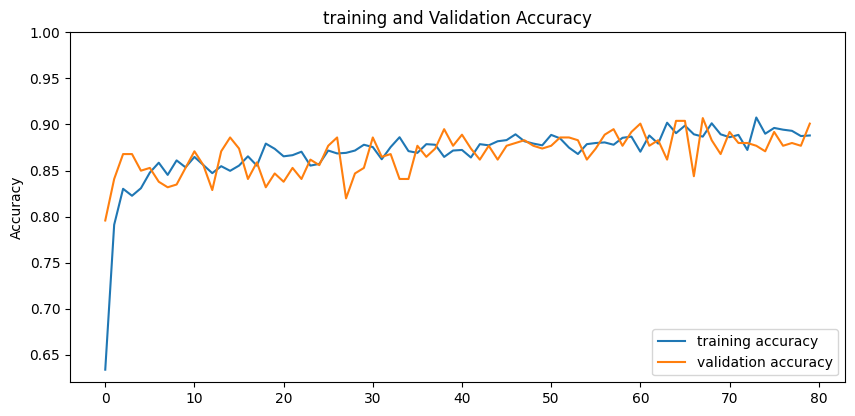

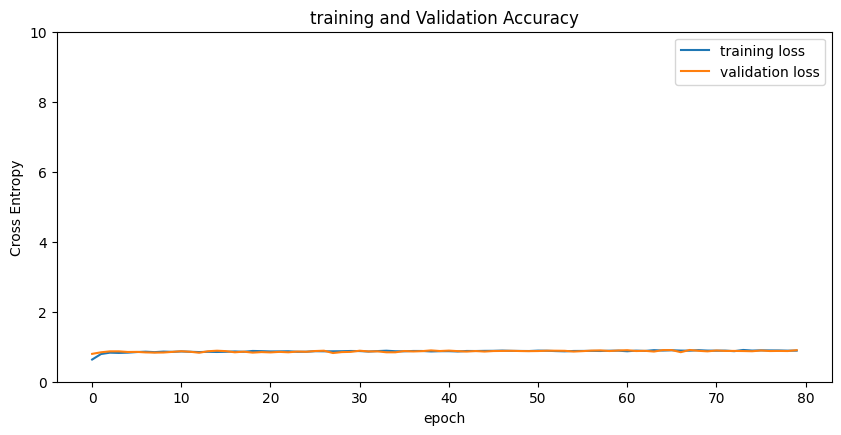

In [ ]:
acc= history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title("training and Validation Accuracy")

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.plot(acc, label='training loss')
plt.plot(val_acc, label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title("training and Validation Accuracy")
plt.xlabel('epoch')
plt.show()

In [ ]:
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  22


In [ ]:
for layer in base_model.layers:
  layer.trainable=True

In [ ]:
base_model.trainable=True
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,078,596 (80.41 MB)

 Trainable params: 21,077,572 (80.40 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
total_epochs=160

In [ ]:
history_fine=model.fit(train_ds,
                       epochs=total_epochs,
                       initial_epoch=history.epoch[-1],
                       validation_data=valid_ds,
                       callbacks=(callbacks_list+ [csv_logger]))

In [ ]:
acc= history_fine.history['accuracy']
val_acc=history_fine.history['val_accuracy']

loss=history_fine.history['loss']
val_loss=history_fine.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title("training and Validation Accuracy")

plt.figure(figsize=(10,10))
plt.subplot(2,1,2)
plt.plot(acc, label='training loss')
plt.plot(val_acc, label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title("training and Validation loss")
plt.xlabel('epoch')
plt.show()

In [ ]:
import numpy as np
image_batch, label_batch=test_ds.as_numpy_iterator().next()
prediction=model.predict_on_batch(image_batch)

plt.figure(figsize=(12,12))
for i in range (9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  actual_label=class_names[label_batch[i]]
  predicted_label=class_names[np.argmax(prediction[i])]
  plt.title(f'actual: {actual_label}, predicted: {predicted_label}')
  plt.axis('off')

plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()

In [ ]:
image_batch, label_batch=test_ds.as_numpy_iterator().next()
prediction=model.predict_on_batch(image_batch)

plt.figure(figsize=(12,12))
for i in range (9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  actual_label=class_names[label_batch[i]]
  predicted_label=class_names[np.argmax(prediction[i])]
  plt.title(f'actual: {actual_label}, predicted: {predicted_label}')
  plt.axis('off')

plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
img=image.load_img('metal1.JPG',target_size=(224,224))

img_array=image.img_to_array(img)
img_array_expanded=np.expand_dims(img_array, axis=0)

img_array_preprocessed=preprocess_input(img_array_expanded)

predictions=model.predict(img_array_preprocessed)

predicted_class= class_names[np.argmax(predictions[0])]

plt.imshow(img)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()

In [ ]:
model.save('waste_classification_model.h5')

In [ ]:
my_model=tf.keras.models.load_model('waste_classification_model.h5')

In [ ]:
loss,acc=my_model.evaluate(test_ds)
print(f"the accuracy of my model is: {acc*100}")

In [ ]:
my_model.summary()

In [ ]:
import tensorflow as tf

In [ ]:
my_model=tf.keras.models.load_model('/content/waste_classification_model13.keras')
my_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,236,820 (241.23 MB)

 Trainable params: 21,078,598 (80.41 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 42,157,198 (160.82 MB)

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('archive1 (6).zip','r')
zip_ref.extractall()
zip_ref.close()
data_dir='/content/dataset-resized'
train_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
validation_split=0.2,
                                                     label_mode='int',
                                                     subset='training',
                                                     seed=1227,
                                                     image_size=(224,224),
                                                     batch_size=32
                                                     )


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [ ]:
valid_ds=tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     validation_split=0.2,
                                                     label_mode='int',
                                                     subset='validation',
                                                     seed=1227,
                                                     image_size=(224,224),
                                                     batch_size=32)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [ ]:
val_batches=tf.data.experimental.cardinality(valid_ds)
test_ds=valid_ds.take(val_batches // 5)
valid_ds=valid_ds.skip(val_batches // 5)

In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds=valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds=test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
class_names=['cardboard','glass', 'metal', 'paper', 'plastic','trash']
num_classes=len(class_names)
class_names, num_classes

(['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], 6)

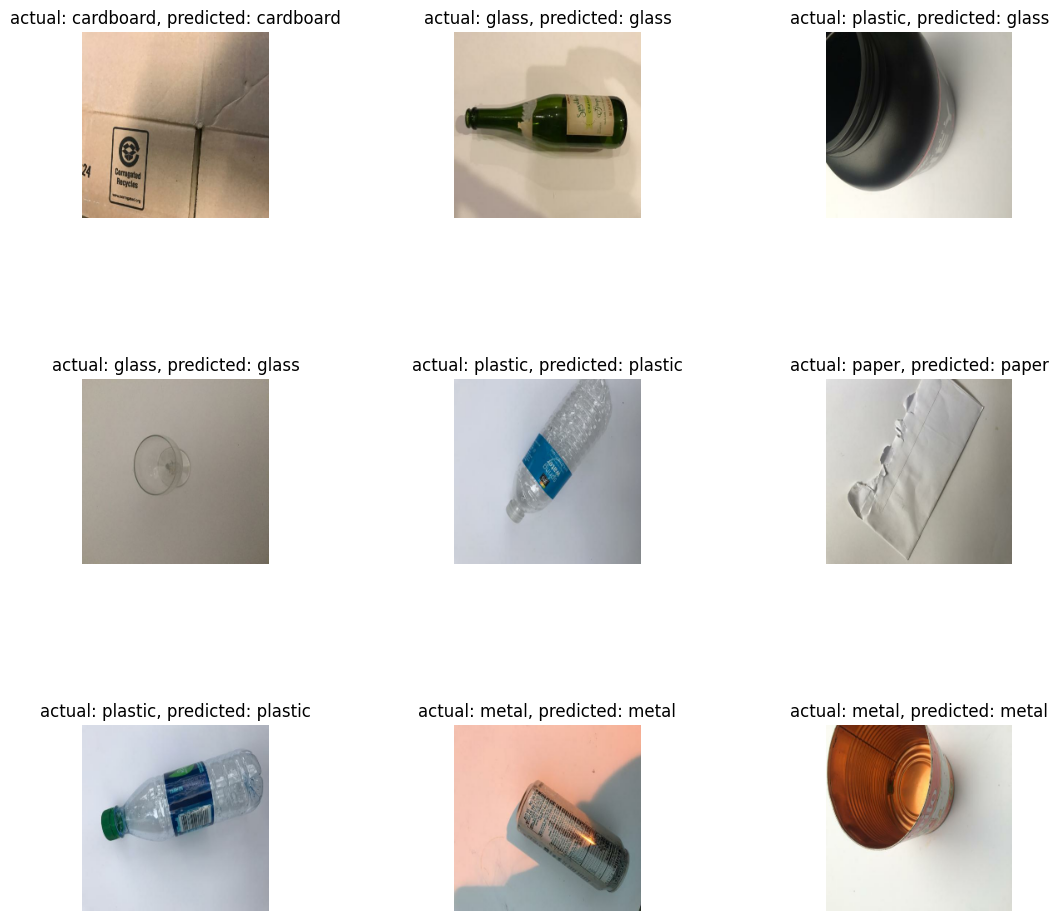

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
image_batch, label_batch=test_ds.as_numpy_iterator().next()
prediction=my_model.predict_on_batch(image_batch)

plt.figure(figsize=(12,12))
for i in range (9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype('uint8'))
  actual_label=class_names[label_batch[i]]
  predicted_label=class_names[np.argmax(prediction[i])]
  plt.title(f'actual: {actual_label}, predicted: {predicted_label}')
  plt.axis('off')

plt.subplots_adjust(wspace=1, hspace=0.5)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


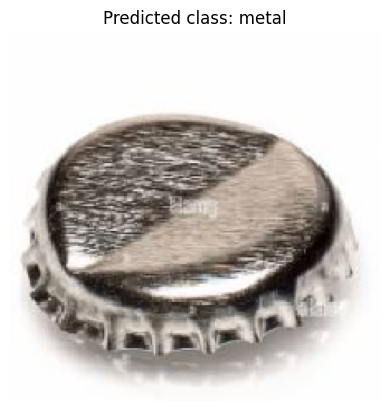

[[0.00383813 0.00794772 0.97042054 0.00414371 0.01064361 0.00300638]]


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
img=image.load_img('/content/metal3.JPG',target_size=(224,224))

img_array=image.img_to_array(img)
img_array_expanded=np.expand_dims(img_array, axis=0)

img_array_preprocessed=preprocess_input(img_array_expanded)

predictions=my_model.predict(img_array_preprocessed)

predicted_class= class_names[np.argmax(predictions[0])]

plt.imshow(img)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()

print(predictions)